# ChromVAR

Run ChromVAR manually.

In [107]:
library(chromVAR)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)
library(Matrix)
library(SummarizedExperiment)
library(motifmatchr)
library(ggplot2)
library(scales)
library(BiocParallel)
set.seed(2017)

In [66]:
register(MulticoreParam(20, progressbar = TRUE))

In [ ]:
PFM_DIR = './data/preiPSC_modisco/'
PFM_FILES = list.files(PFM_DIR)
PFM_NAMES = lapply(strsplit(PFM_FILES, "\\."), "[[", 1)
PFM_FILES = paste(PFM_DIR, PFM_FILES, sep='')
PFM_NAMES
PFM_FILES

[[1]]
[1] "pattern_0"

[[2]]
[1] "pattern_1"

[[3]]
[1] "pattern_10"

[[4]]
[1] "pattern_11"

[[5]]
[1] "pattern_12"

[[6]]
[1] "pattern_2"

[[7]]
[1] "pattern_3"

[[8]]
[1] "pattern_4"

[[9]]
[1] "pattern_5"

[[10]]
[1] "pattern_6"

[[11]]
[1] "pattern_7"

[[12]]
[1] "pattern_8"

[[13]]
[1] "pattern_9"

In [29]:
MAX_MOTIF_LEN = 30
pfms = list()
j = 1 
for (i in seq(length(PFM_FILES))) {
    raw_pfms = t(as.matrix(read.table(PFM_FILES[i])))
    rownames(raw_pfms) = c("A", "C", "G", "T")
    if (ncol(raw_pfms) < MAX_MOTIF_LEN) {
        pfms[[j]] = PFMatrix(ID=unlist(PFM_NAMES[i]),
                            name=unlist(PFM_NAMES[i]),
                            bg=c(A=0.25, C=0.25, G=0.25, T=0.25),
                            profileMatrix=raw_pfms)
        j = j+1
    }
}

In [30]:
motifs = do.call(PFMatrixList, c(pfms, use.names=T))
motifs

PFMatrixList of length 12

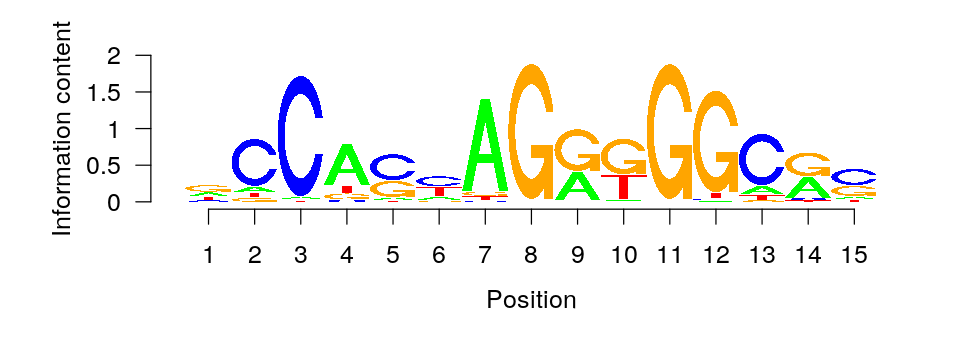

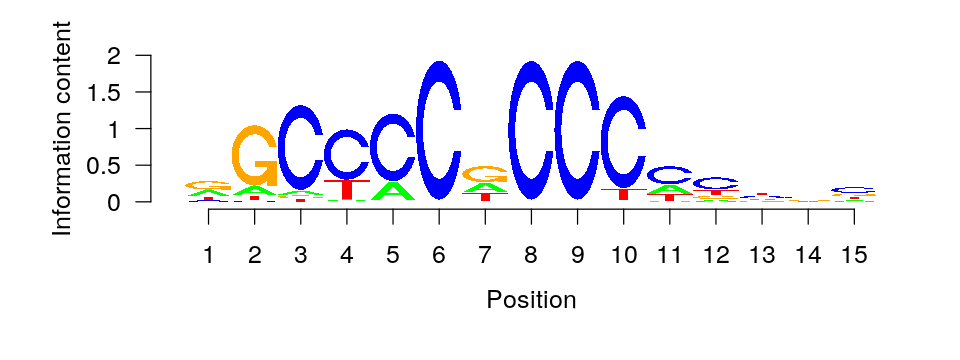

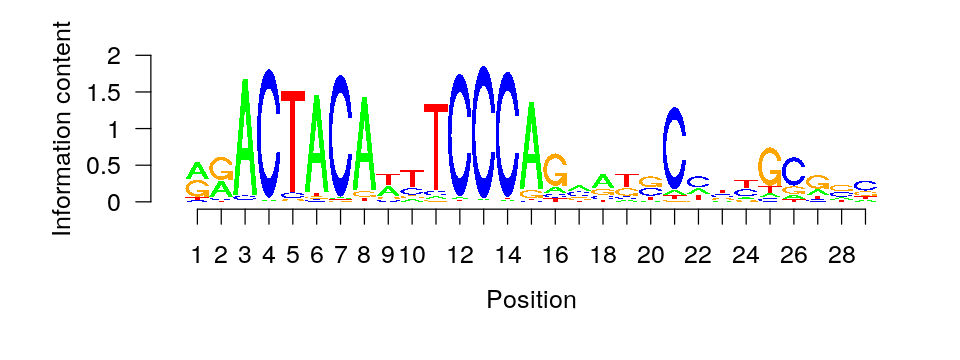

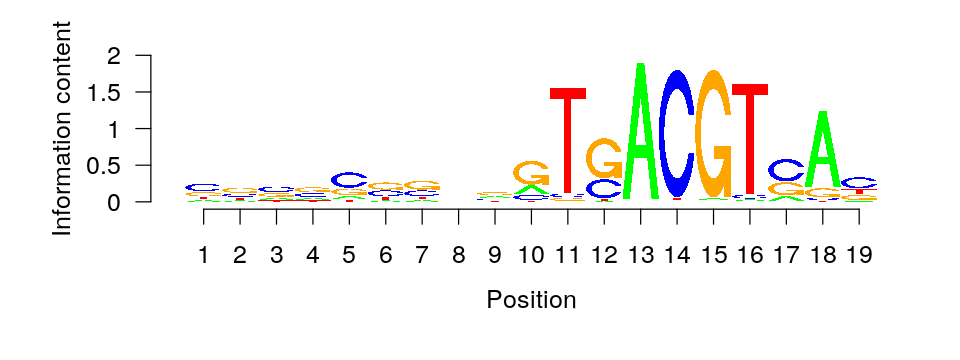

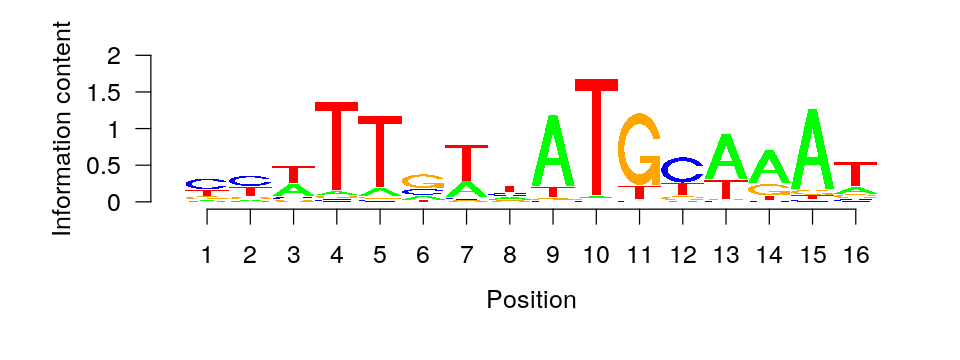

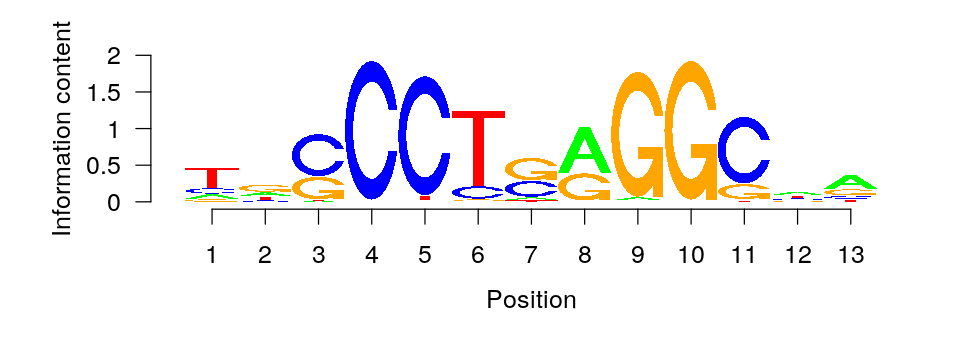

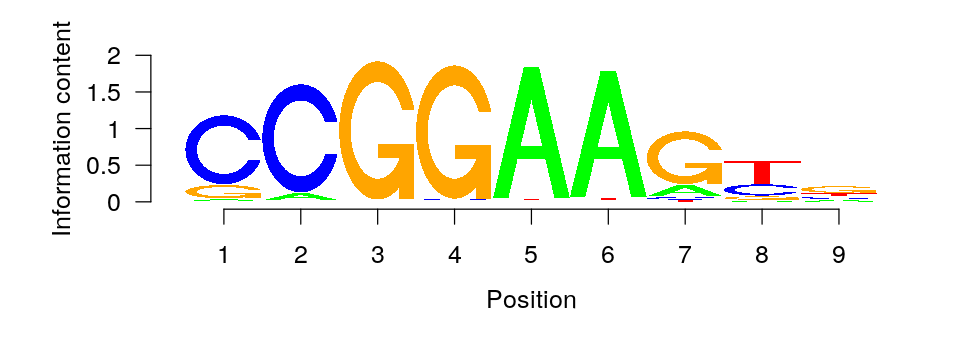

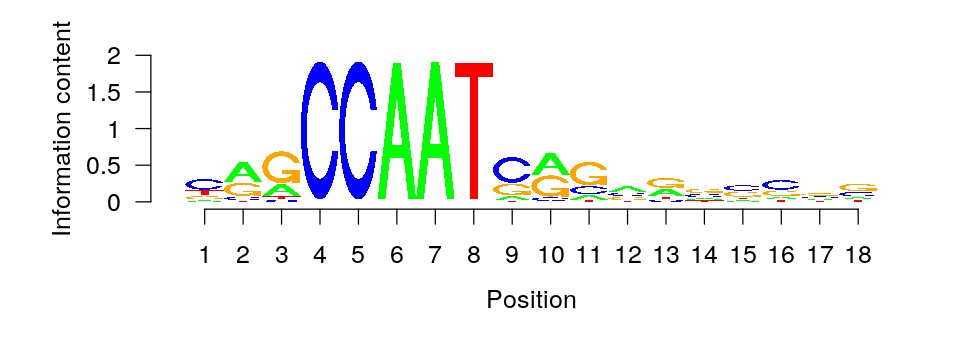

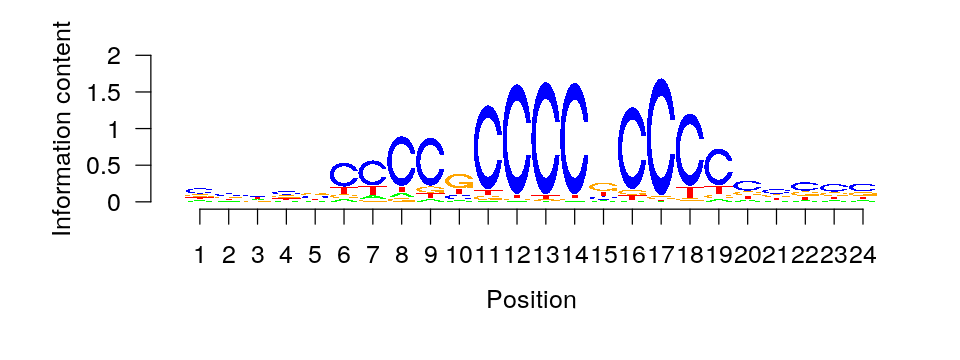

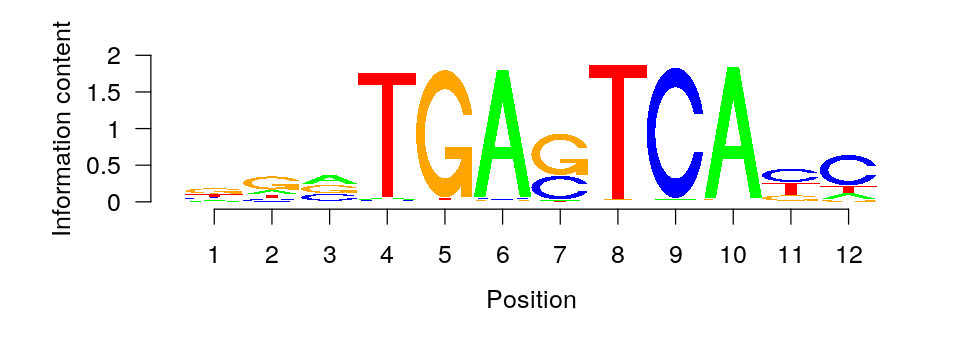

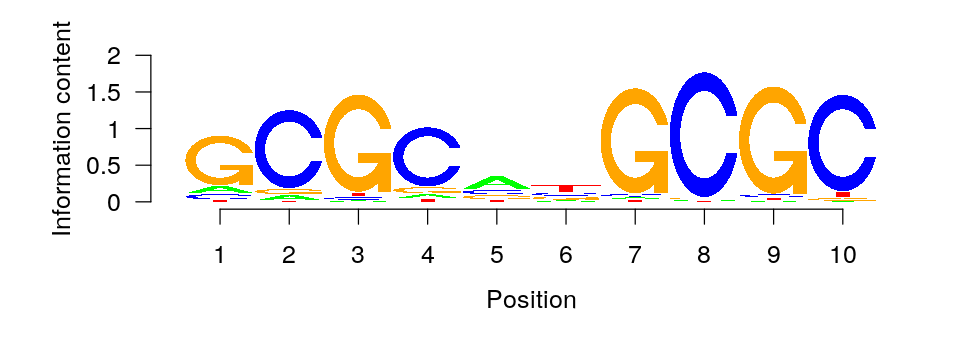

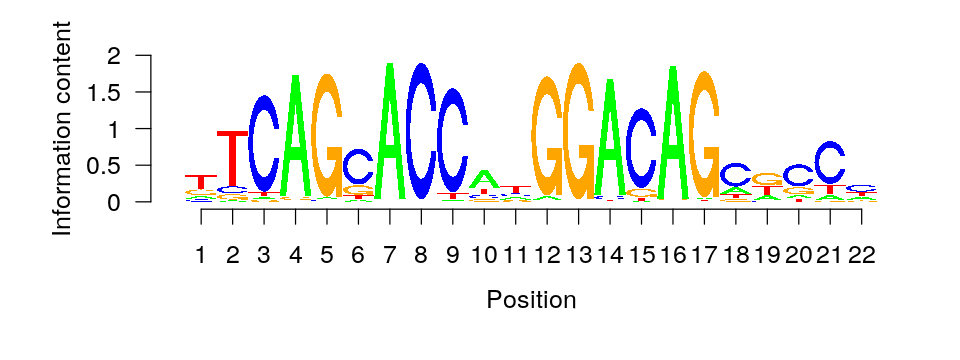

In [31]:
for (i in seq(length(motifs))) {
    icm <- toICM(pfms[[i]], pseudocounts=0.8, schneider=TRUE)
    seqLogo(icm)
}

In [102]:
motif_names = c()
for (i in seq(length(motifs))) {
    motif_names = c(motif_names, name(motifs[[i]]))
}
motif_names

[1] "pattern_0"  "pattern_1"  "pattern_10" "pattern_11" "pattern_2" 
 [6] "pattern_3"  "pattern_4"  "pattern_5"  "pattern_6"  "pattern_7" 
[11] "pattern_8"  "pattern_9"

## Load Data

In [39]:
pmat = readMM("../20200206_pmat_snapATAC/sessions/20200520_n68916/pmat.overlap.smallpeaks.sparse.mm")
pmat = as(pmat, "dgCMatrix")
dim(pmat)

[1]  68916 803958

In [40]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 68916     5

,barcode,sample,umap1,umap2,cells
,<fct>,<fct>,<dbl>,<dbl>,<chr>
D0_AAACAACGACGATTAC,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC
D0_AAACAACGAGCGCACT,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT
D0_AAACACGCTACGCCAC,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG
D0_AAACACGCTCCTCAAA,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA


In [41]:
regions = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.overlap.smallpeaks.bed")
names(regions) = c("chr", "bp1", "bp2")
regions$site_name <- paste(regions$chr, regions$bp1, regions$bp2, sep="_")
row.names(regions) <- regions$site_name
dim(regions)
head(regions)

[1] 803958      4

,chr,bp1,bp2,site_name
,<fct>,<int>,<int>,<chr>
chr1_97145604_97145864,chr1,97145604,97145864,chr1_97145604_97145864
chr1_7538148_7538363,chr1,7538148,7538363,chr1_7538148_7538363
chr1_93196678_93196894,chr1,93196678,93196894,chr1_93196678_93196894
chr1_187577713_187577913,chr1,187577713,187577913,chr1_187577713_187577913
chr1_53278065_53278265,chr1,53278065,53278265,chr1_53278065_53278265
chr1_177176832_177177032,chr1,177176832,177177032,chr1_177176832_177177032


In [53]:
peaks_gr = GRanges(sub("_", "-", sub("_", ":", rownames(regions))))
peaks_gr

GRanges object with 803958 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1   97145604-97145864      *
       [2]     chr1     7538148-7538363      *
       [3]     chr1   93196678-93196894      *
       [4]     chr1 187577713-187577913      *
       [5]     chr1   53278065-53278265      *
       ...      ...                 ...    ...
  [803954]     chrY     7500307-7500509      *
  [803955]     chrY     7447984-7448191      *
  [803956]     chrY   14733640-14733856      *
  [803957]     chrY   12662452-12662752      *
  [803958]     chrY   12681580-12681865      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [42]:
# binarize the matrix (could also do outlier removal)
pmat@x[pmat@x > 0] <- 1

In [50]:
pmatRowSums = Matrix::rowSums(pmat)

In [48]:
pmatColSums = Matrix::colSums(pmat)

In [51]:
min(pmatRowSums)

[1] 316

In [49]:
min(pmatColSums)

[1] 21

## ChromVAR

In [52]:
GENOME = BSgenome.Hsapiens.UCSC.hg38

In [57]:
rse <- SummarizedExperiment(
                 assays = list(counts = t(pmat)), 
                 rowRanges = peaks_gr, 
                 colData = DataFrame(Cell_Type=1:nrow(pmat), depth=pmatRowSums)
    );

In [60]:
rse <- addGCBias(rse, genome = GENOME);

In [61]:
motif_mm <- matchMotifs(motifs, rse, genome = GENOME);

In [141]:
motif_mm_mat = assay(motif_mm)
colnames(motif_mm_mat) = motif_names

In [75]:
dev <- computeDeviations(object = rse, annotations = motif_mm)

  |======================================================================| 100%



In [76]:
dev_mat = t(assay(dev))

In [103]:
colnames(dev_mat) = motif_names
head(dev_mat)

pattern_0,pattern_1,pattern_10,pattern_11,pattern_2,pattern_3,pattern_4,pattern_5,pattern_6,pattern_7,pattern_8,pattern_9
-0.02098398,-0.10369027,-0.008096558,0.07021718,-0.4376698,-0.03641261,-0.001597141,0.05227520,-0.037303290,0.07719716,0.014543006,0.02126624
0.01327868,-0.09071955,0.016354326,0.02216430,-0.4554786,-0.04795403,-0.024439416,-0.04914041,-0.007822111,0.12018563,0.056421728,0.02333182
0.03740925,-0.12769006,-0.025313821,0.03305338,-0.4263956,-0.09221816,0.026243515,-0.02634547,-0.023260923,0.10970377,0.074720628,-0.01584042
-0.03085638,-0.09974925,0.120797123,0.08932015,-0.4598844,-0.06796675,0.025042017,0.01638494,-0.038852844,0.19223573,0.061205826,0.05136439
-0.04739338,-0.12646549,-0.064759690,-0.34247558,-0.2578187,-0.02364054,0.041256681,-0.16735347,-0.039810961,0.12418198,-0.101265875,-0.02821161
-0.06174775,-0.08496426,-0.005307621,0.08693301,-0.4179228,-0.04744051,0.050807490,-0.04135140,-0.037068281,0.25422134,0.007501879,-0.02129885


In [81]:
variability <- computeVariability(dev)

  |======================================================================| 100%



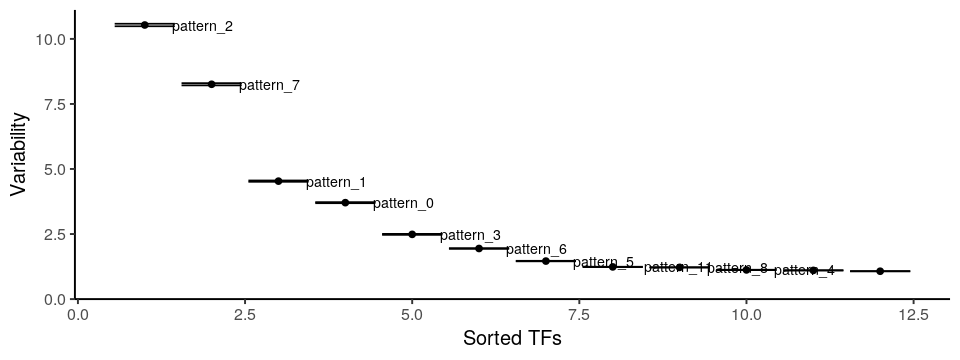

In [83]:
plotVariability(variability, use_plotly = FALSE, n = 10) 

In [245]:
cur_pattern = "pattern_5"

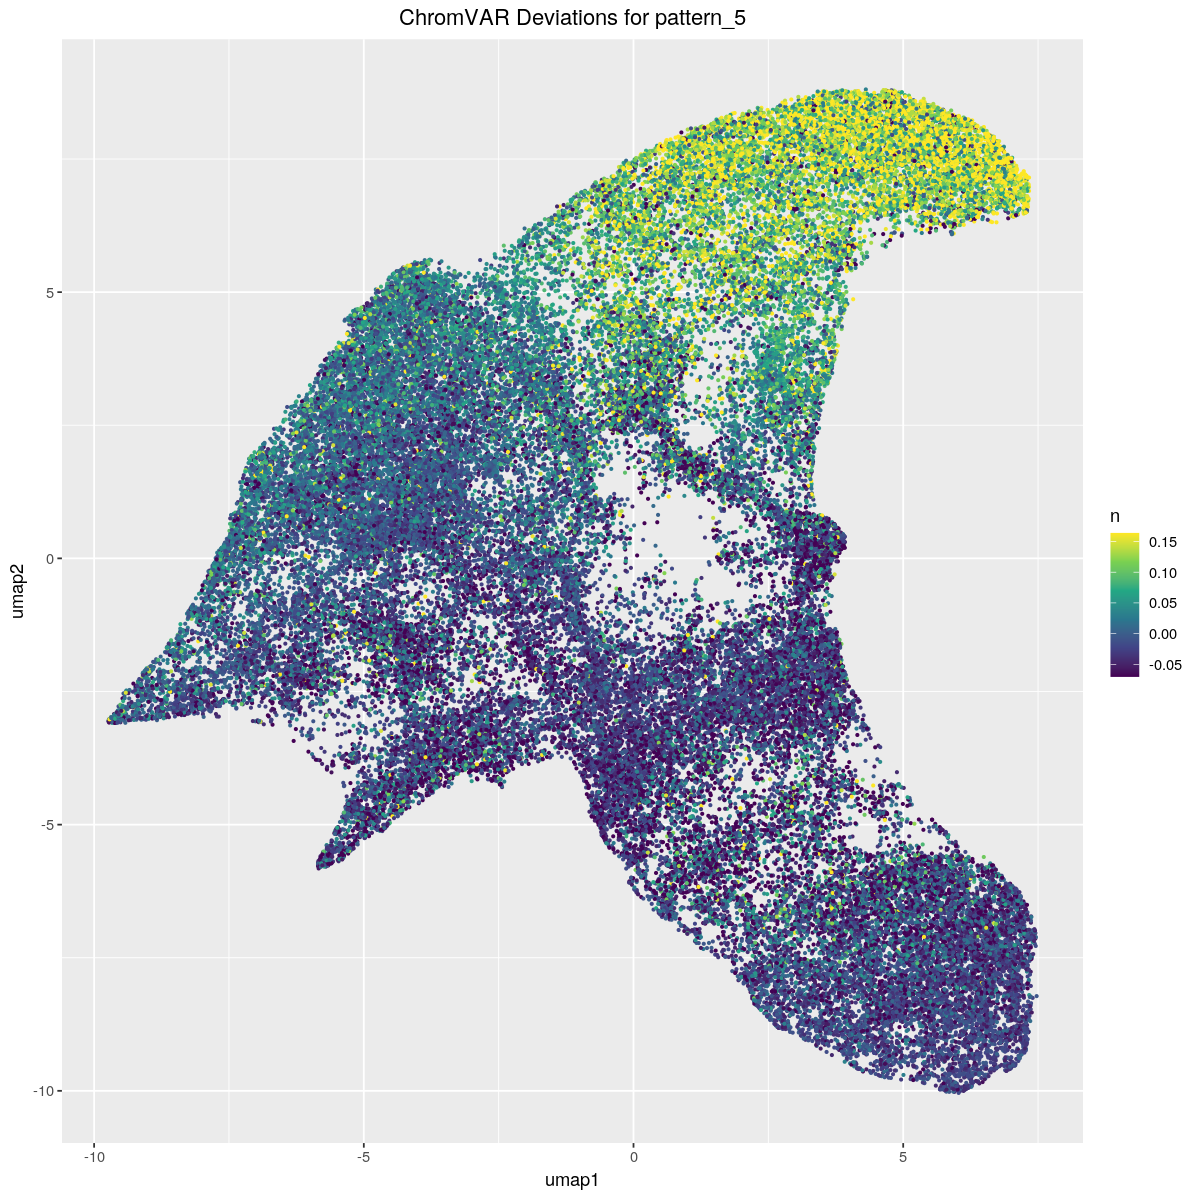

In [246]:
options(repr.plot.width = 10, repr.plot.height = 10)

cur_dev = dev_mat[,cur_pattern]

df = data.frame(metaData, n=cur_dev)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.5, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
scale_color_viridis_c(limit=c(quantile(cur_dev, 0.1),
                              quantile(cur_dev, 0.95)), 
                      oob = squish) +
ggtitle(sprintf("ChromVAR Deviations for %s", cur_pattern)) + 
theme(plot.title = element_text(hjust = 0.5)) 

In [247]:
sum(motif_mm_mat[, cur_pattern])

[1] 18368

In [248]:
frip = 100*Matrix::rowSums(pmat[, motif_mm_mat[, cur_pattern]])/pmatRowSums

In [249]:
cor(frip, dev_mat[,cur_pattern], method='spearman')

[1] 0.4439363

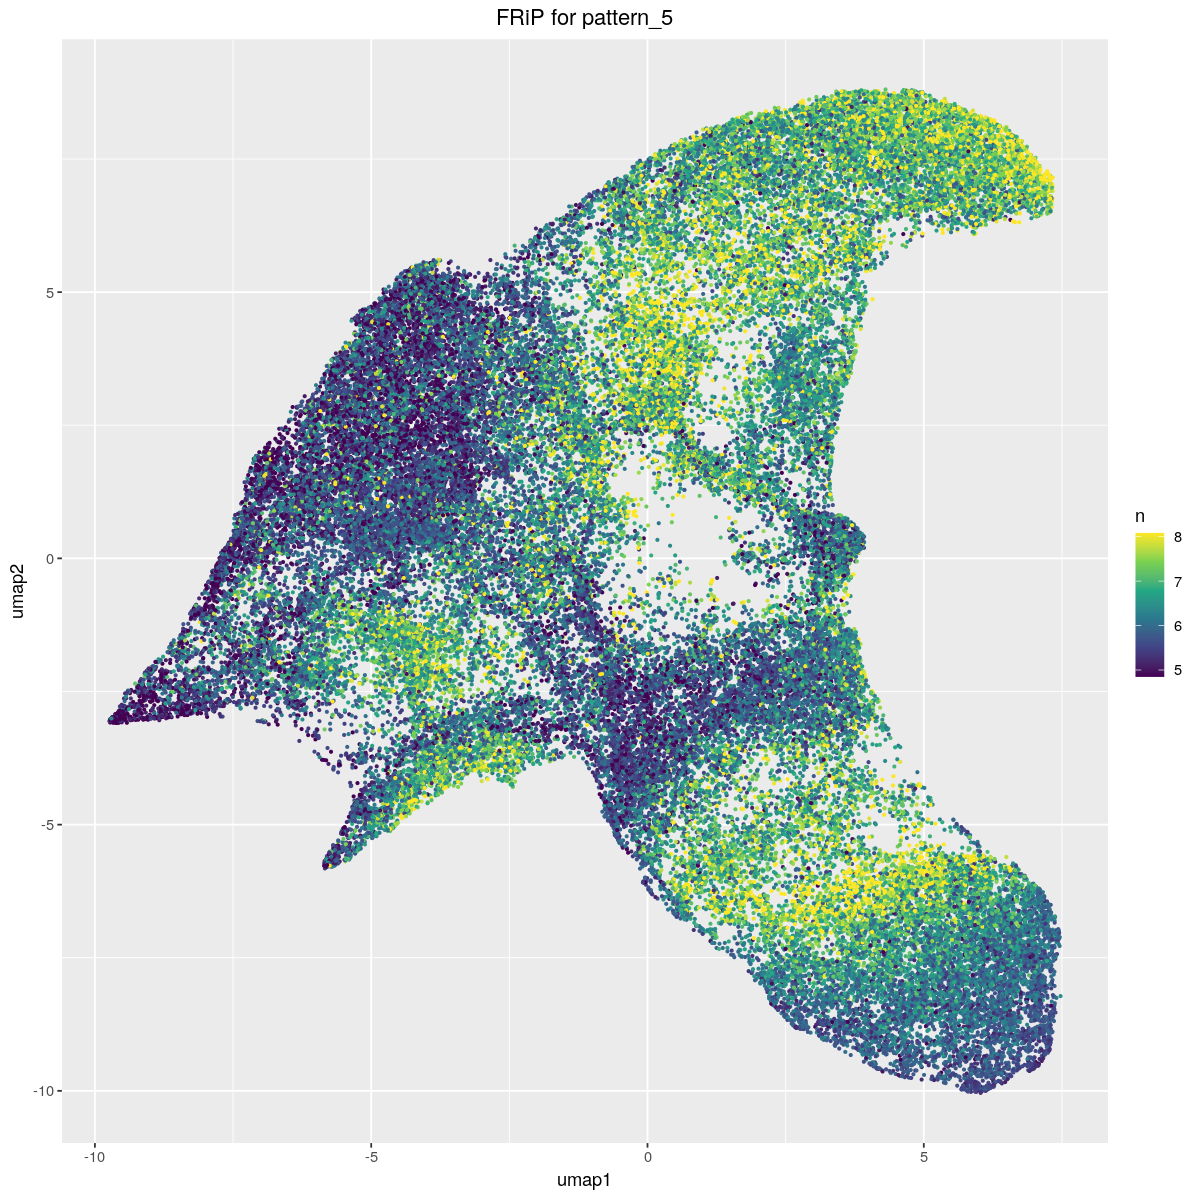

In [250]:
options(repr.plot.width = 10, repr.plot.height = 10)

df = data.frame(metaData, n=frip)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
geom_point(size=0.5, alpha=1, aes(x=umap1 , y=umap2, col=n)) +
scale_color_viridis_c(limit=c(quantile(frip, 0.05),
                              quantile(frip, 0.95)), 
                      oob = squish) +
ggtitle(sprintf("FRiP for %s", cur_pattern)) + 
theme(plot.title = element_text(hjust = 0.5)) 

### SessionInfo

In [236]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scales_1.1.0                      ggplot2_3.3.0                    
 [3] motifmatchr_1.8.0                 SummarizedExperiment_1.16.1      
 [5] DelayedArray_0.12.3               BiocParallel_1.20.1              
 [7] matrixStats_0.56.0                Biobase_2.46.0   